# DRQN Model for VizDoom Environment

### Description
This notebook implements a Deep Recurrent Q-Learning (DRQN) model for the VizDoom environment using TensorFlow.



### Key Components:
- **DRQN Model**: Including three convolutional layers and the Recurrent Neural Network. It helps to process the sequential data and hidden states and allows the agent to make decisions based on past and present views.
- **Hyperparameter Tuning**: Modify the subsequent hyperparameters to enhance the performance:

    - `learning_rate`: Determines how quickly the model learns from the training data.
    -  `batch_size`: Adjusting this parameter can affect the stability and efficiency of the training process.
    - `discount_factor`: The reward discount factor, which affects how important future rewards are to the agent when making decisions.
    
- **Visualisations**: Set up pyplot to visualise the results.

### How to Run:
1. **Setup**: Ensure all required libraries and packages are installed, and the VizDoom environment is properly configured. Modify the path for loading the VizDoom environment and storing the model as needed.

2. **Parameter Tuning**: Adjust the parameters in the 'Hyperparameters' section as needed.

3. **Execution**: Run the cells sequentially to train the model. Monitor the output for performance metrics and visualisations.


### References

- Playing Doom Game using DRQN/9.5 Doom Game Using DRQN.ipynb
[https://github.com/sudharsan13296/Hands-On-Reinforcement-Learning-With-Python/blob/5440811df8da575eb41b131f897ddd8a7ce40d5f/09.%20Playing%20Doom%20Game%20using%20DRQN/9.5%20Doom%20Game%20Using%20DRQN.ipynb]


 First let us import all necessary libraries

In [1]:
#!pip install tensorflow
#!pip install tensorrt ##solve: "TF-TRT Warning: Could not find TensorRT"##
#!pip install vizdoom

In [2]:
import tensorflow as tf
#import tensorrt
import numpy as np
import math
from vizdoom import *
import timeit
import math
import os
import sys

import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()

In [3]:
import os
current_directory = os.getcwd()
files_and_directories = os.listdir(current_directory)
print("Current working directory:", current_directory)

Current working directory: /Users/Lei/Documents/master/semester2/Reinforcement_Learning/cw2


In [4]:
%cd /Users/Lei/github/VizDoom/scenarios/
#%cd ~/ViZDoom/scenarios/

/Users/Lei/github/ViZDoom/scenarios


In [5]:
game = DoomGame()

# Load the correct configuration (TESTING)
game.load_config("deadly_corridor.cfg")

# Load the correct scenario (in our case deadly_corridor scenario)
game.set_doom_scenario_path("deadly_corridor.wad")

#game.set_window_visible(False) ##no pop out window##
game.init()

In [6]:
game.close()

In [7]:
def get_input_shape(Image,Filter,Stride):
    layer1 = math.ceil(((Image - Filter + 1) / Stride))

    o1 = math.ceil((layer1 / Stride))

    layer2 = math.ceil(((o1 - Filter + 1) / Stride))

    o2 = math.ceil((layer2 / Stride))

    layer3 = math.ceil(((o2 - Filter + 1) / Stride))

    o3 = math.ceil((layer3  / Stride))

    return int(o3)

**DRQN model:**

In [8]:
class DRQN():
    def __init__(self, input_shape, num_actions, inital_learning_rate):

        # first, we initialize all the hyperparameters

        self.tfcast_type = tf.float32

        # shape of our input which would be (length, width, channels)
        self.input_shape = input_shape

        # number of actions in the environment
        self.num_actions = num_actions

        # learning rate for the neural network
        self.learning_rate = inital_learning_rate

        # now we will define the hyperparameters of the convolutional neural network

        # filter size
        self.filter_size = 5

        # number of filters
        self.num_filters = [16, 32, 64]

        # stride size
        self.stride = 2

        # pool size
        self.poolsize = 2

        # shape of our convolutional layer
        self.convolution_shape = get_input_shape(input_shape[0], self.filter_size, self.stride) * get_input_shape(input_shape[1], self.filter_size, self.stride) * self.num_filters[2]

        # now we define the hyperparameters of our recurrent neural network and the final feed forward layer

        # number of neurons
        self.cell_size = 100

        # number of hidden layers
        self.hidden_layer = 50

        # drop out probability
        self.dropout_probability = [0.3, 0.2]

        # hyperparameters for optimization
        self.loss_decay_rate = 0.96
        self.loss_decay_steps = 180


        # initialize all the variables for the CNN

        # we initialize the placeholder for input whose shape would be (length, width, channel)
        self.input = tf.compat.v1.placeholder(shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), dtype = self.tfcast_type)

        # we will also initialize the shape of the target vector whose shape is equal to the number of actions
        self.target_vector = tf.compat.v1.placeholder(shape = (self.num_actions, 1), dtype = self.tfcast_type)

        # initialize feature maps for our corresponding 3 filters
        self.features1 = tf.Variable(initial_value = np.random.rand(self.filter_size, self.filter_size, input_shape[2], self.num_filters[0]),
                                     dtype = self.tfcast_type)

        self.features2 = tf.Variable(initial_value = np.random.rand(self.filter_size, self.filter_size, self.num_filters[0], self.num_filters[1]),
                                     dtype = self.tfcast_type)


        self.features3 = tf.Variable(initial_value = np.random.rand(self.filter_size, self.filter_size, self.num_filters[1], self.num_filters[2]),
                                     dtype = self.tfcast_type)

        # initialize variables for RNN


        self.h = tf.Variable(initial_value = np.zeros((1, self.cell_size)), dtype = self.tfcast_type)

        # hidden to hidden weight matrix
        self.rW = tf.Variable(initial_value = np.random.uniform(
                                            low = -np.sqrt(6. / (self.convolution_shape + self.cell_size)),
                                            high = np.sqrt(6. / (self.convolution_shape + self.cell_size)),
                                            size = (self.convolution_shape, self.cell_size)),
                              dtype = self.tfcast_type)

        # input to hidden weight matrix
        self.rU = tf.Variable(initial_value = np.random.uniform(
                                            low = -np.sqrt(6. / (2 * self.cell_size)),
                                            high = np.sqrt(6. / (2 * self.cell_size)),
                                            size = (self.cell_size, self.cell_size)),
                              dtype = self.tfcast_type)

        # hiddent to output weight matrix

        self.rV = tf.Variable(initial_value = np.random.uniform(
                                            low = -np.sqrt(6. / (2 * self.cell_size)),
                                            high = np.sqrt(6. / (2 * self.cell_size)),
                                            size = (self.cell_size, self.cell_size)),
                              dtype = self.tfcast_type)
        # bias
        self.rb = tf.Variable(initial_value = np.zeros(self.cell_size), dtype = self.tfcast_type)
        self.rc = tf.Variable(initial_value = np.zeros(self.cell_size), dtype = self.tfcast_type)


        # initialize weights and bias of feed forward network

        # weights
        self.fW = tf.Variable(initial_value = np.random.uniform(
                                            low = -np.sqrt(6. / (self.cell_size + self.num_actions)),
                                            high = np.sqrt(6. / (self.cell_size + self.num_actions)),
                                            size = (self.cell_size, self.num_actions)),
                              dtype = self.tfcast_type)

        # bias
        self.fb = tf.Variable(initial_value = np.zeros(self.num_actions), dtype = self.tfcast_type)

        # learning rate
        self.step_count = tf.Variable(initial_value = 0, dtype = self.tfcast_type)
        self.learning_rate = tf.compat.v1.train.exponential_decay(self.learning_rate,
                                                   self.step_count,
                                                   self.loss_decay_steps,
                                                   self.loss_decay_steps,
                                                   staircase = False)


        # build the network

        # first convolutional layer
        self.conv1 = tf.nn.conv2d(input = tf.reshape(self.input, shape = (1, self.input_shape[0], self.input_shape[1], self.input_shape[2])), filters = self.features1, strides = [1, self.stride, self.stride, 1], padding = "VALID")
        self.relu1 = tf.nn.relu(self.conv1)
        self.pool1 = tf.nn.max_pool2d(input=self.relu1, ksize = [1, self.poolsize, self.poolsize, 1], strides = [1, self.stride, self.stride, 1], padding = "SAME")

        # second convolutional layer
        self.conv2 = tf.nn.conv2d(input = self.pool1, filters = self.features2, strides = [1, self.stride, self.stride, 1], padding = "VALID")
        self.relu2 = tf.nn.relu(self.conv2)
        self.pool2 = tf.nn.max_pool2d(input=self.relu2, ksize = [1, self.poolsize, self.poolsize, 1], strides = [1, self.stride, self.stride, 1], padding = "SAME")

        # third convolutional layer
        self.conv3 = tf.nn.conv2d(input = self.pool2, filters = self.features3, strides = [1, self.stride, self.stride, 1], padding = "VALID")
        self.relu3 = tf.nn.relu(self.conv3)
        self.pool3 = tf.nn.max_pool2d(input=self.relu3, ksize = [1, self.poolsize, self.poolsize, 1], strides = [1, self.stride, self.stride, 1], padding = "SAME")

        # add dropout and reshape the input
        self.drop1 = tf.nn.dropout(self.pool3, rate=1 - (self.dropout_probability[0]))
        self.reshaped_input = tf.reshape(self.drop1, shape = [1, -1])


        # build recurrent neural network which takes the input from the last layer of convolutional network
        self.h = tf.tanh(tf.matmul(self.reshaped_input, self.rW) + tf.matmul(self.h, self.rU) + self.rb)
        self.o = tf.nn.softmax(tf.matmul(self.h, self.rV) + self.rc)

        # add drop out to RNN
        self.drop2 = tf.nn.dropout(self.o, rate=1 - (self.dropout_probability[1]))

        # we feed the result of RNN to the feed forward layer
        self.output = tf.reshape(tf.matmul(self.drop2, self.fW) + self.fb, shape = [-1, 1])
        self.prediction = tf.argmax(self.output)

        # compute loss
        self.loss = tf.reduce_mean(tf.square(self.target_vector - self.output))

        # we use Adam optimizer for minimizing the error
        self.optimizer = tf.compat.v1.train.AdamOptimizer(self.learning_rate)

        # compute gradients of the loss and update the gradients
        self.gradients = self.optimizer.compute_gradients(self.loss)
        self.update = self.optimizer.apply_gradients(self.gradients)

        self.parameters = (self.features1, self.features2, self.features3,
                           self.rW, self.rU, self.rV, self.rb, self.rc,
                           self.fW, self.fb)


In [9]:
class ExperienceReplay():
    def __init__(self, buffer_size):

        # buffer for holding the transistion
        self.buffer = []

        # size of the buffer
        self.buffer_size = buffer_size

    # we remove the old transistion if buffer size has reached it's limit. Think off the buffer as a queue when new
    # one comes, old one goes off

    def appendToBuffer(self, memory_tuplet):
        if len(self.buffer) > self.buffer_size:
            for i in range(len(self.buffer) - self.buffer_size):
                self.buffer.remove(self.buffer[0])
        self.buffer.append(memory_tuplet)


    # define a function called sample for sampling some random n number of transistions

    def sample(self, n):
        memories = []

        for i in range(n):
            memory_index = np.random.randint(0, len(self.buffer))
            memories.append(self.buffer[memory_index])
        return memories

**Reward shaping:**

In [10]:
def shape_reward(reward, game_state, prev_damage_taken, prev_hitcount, prev_ammo):
    # Extract game variables from the game state object
    health = game_state.game_variables[0]
    damage_taken = game_state.game_variables[1]
    hitcount = game_state.game_variables[2]

    # Set ammo to a default value if not available in game_state.game_variables
    ammo = 0
    if len(game_state.game_variables) > 3:
        ammo = game_state.game_variables[3]

    ## Debug print statements ##
    #print("Reward before shaping:", reward)
    #print("Health:", health)
    #print("Damage Taken:", damage_taken)
    #print("Hitcount:", hitcount)
    #print("Ammo:", ammo)

    # Initialize shaped reward with the original reward
    shaped_reward = reward

    # Calculate deltas for damage_taken, hitcount, and ammo
    damage_taken_delta = -damage_taken + prev_damage_taken
    hitcount_delta = hitcount - prev_hitcount
    ammo_delta = ammo - prev_ammo

    # Reward shaping logic
    shaped_reward += damage_taken_delta * 10  # Penalty for taking damage
    shaped_reward += hitcount_delta * 200  # Reward for increasing hit count
    shaped_reward += ammo_delta * 5  # Penalty for decreasing ammo

    #print("Shaped reward:", shaped_reward)

    return shaped_reward, damage_taken, hitcount, ammo

**Training model:**

In [11]:
def train(num_episodes, episode_length, learning_rate, scenario = "deadly_corridor.cfg", map_path = 'map01', render = False):

    # discount parameter for Q-value computation
    discount_factor = .99

    # frequency for updating the experience in the buffer
    update_frequency = 5
    store_frequency = 50

    # for printing the output
    print_frequency = 1000

    # initialize variables for storing total rewards and total loss
    total_reward = 0
    total_loss = 0
    old_q_value = 0

    # Initialize variables for storing previous damage taken, hit count, and ammo
    prev_damage_taken = 0
    prev_hitcount = 0
    prev_ammo = 0

    # initialize lists for storing the episodic rewards and losses
    rewards = []
    losses = []

    # okay, now let us get to the action!

    # first, we initialize our doomgame environment
    game = DoomGame()

    # specify the path where our scenario file is located
    game.set_doom_scenario_path(scenario)

    # specify the path of map file
    game.set_doom_map(map_path)

    # then we set screen resolution and screen format
    game.set_screen_resolution(ScreenResolution.RES_256X160)
    game.set_screen_format(ScreenFormat.RGB24)

    # we can add particles and effetcs we needed by simply setting them to true or false
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)
    game.set_render_messages(False)
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)

    # now we will specify buttons that should be available to the agent
    game.add_available_button(Button.MOVE_LEFT)
    game.add_available_button(Button.MOVE_RIGHT)
    game.add_available_button(Button.TURN_LEFT)
    game.add_available_button(Button.TURN_RIGHT)
    game.add_available_button(Button.MOVE_FORWARD)
    game.add_available_button(Button.MOVE_BACKWARD)
    game.add_available_button(Button.ATTACK)


    # okay,now we will add one more button called delta. The above button will only work
    # like a keyboard keys and will have only boolean values.

    # so we use delta button which emulates a mouse device which will have positive and negative values
    # and it will be useful in environment for exploring

    game.add_available_button(Button.TURN_LEFT_RIGHT_DELTA, 90)
    game.add_available_button(Button.LOOK_UP_DOWN_DELTA, 90)

    # initialize an array for actions
    actions = np.zeros((game.get_available_buttons_size(), game.get_available_buttons_size()))
    count = 0
    for i in actions:
        i[count] = 1
        count += 1
    actions = actions.astype(int).tolist()


    # then we add the game variables, ammo, health, and killcount
    #game.add_available_game_variable(GameVariable.AMMO0)
    #game.add_available_game_variable(GameVariable.KILLCOUNT)
    game.add_available_game_variable(GameVariable.HEALTH)
    game.add_available_game_variable(GameVariable.DAMAGE_TAKEN)
    game.add_available_game_variable(GameVariable.HITCOUNT)
    game.add_available_game_variable(GameVariable.SELECTED_WEAPON_AMMO)

    

    # we set episode_timeout to terminate the episode after some time step
    # we also set episode_start_time which is useful for skipping intial events

    game.set_episode_timeout(6 * episode_length)
    game.set_episode_start_time(10)
    game.set_window_visible(render)

    # we can also enable sound by setting set_sound_enable to true
    game.set_sound_enabled(False)

    # we set living reward to 0 which the agent for each move it does even though the move is not useful
    game.set_living_reward(0)

    # doom has different modes such as player, spectator, asynchronous player and asynchronous spectator

    # in spectator mode humans will play and agent will learn from it.
    # in player mode, agent actually plays the game, so we use player mode.

    game.set_mode(Mode.PLAYER)

    # okay, So now we, initialize the game environment
    game.init()


    # now, let us create instance to our DRQN class and create our both actor and target DRQN networks
    actionDRQN = DRQN((160, 256, 3), game.get_available_buttons_size() - 2, learning_rate)
    targetDRQN = DRQN((160, 256, 3), game.get_available_buttons_size() - 2, learning_rate)

    # we will also create instance to the ExperienceReplay class with the buffer size of 1000
    experiences = ExperienceReplay(1000)

    # for storing the models
    saver = tf.compat.v1.train.Saver({v.name: v for v in actionDRQN.parameters}, max_to_keep = 1)


    # now let us start the training process
    # we initialize variables for sampling and storing transistions from the experience buffer
    sample = 5
    store = 50

    # start the tensorflow session
    with tf.compat.v1.Session() as sess:

        # initialize all tensorflow variables

        sess.run(tf.compat.v1.global_variables_initializer())

        for episode in range(num_episodes):
            # start the new episode
            game.new_episode()

            # play the episode till it reaches the episode length
            for frame in range(episode_length):
                #total_reward = 0
                
                # get the game state
                state = game.get_state()
                s = state.screen_buffer

                # select the action
                a = actionDRQN.prediction.eval(feed_dict = {actionDRQN.input: s})[0]
                action = actions[a]

                # perform the action and store the reward
                reward = game.make_action(action)
                
                

                # Optionally, apply reward shaping
                shaped_reward, prev_damage_taken, prev_hitcount, prev_ammo = shape_reward(reward, state, prev_damage_taken, prev_hitcount, prev_ammo)
                

                # update total rewad
                total_reward += shaped_reward

                # Store transition in experience replay buffer
                experiences.appendToBuffer((s, action, shaped_reward))
            
                # Sample experiences from the buffer for training
                if frame % sample == 0:
                    memory = experiences.sample(1)
                    mem_frame = memory[0][0]
                    mem_action = memory[0][1]
                    mem_reward = memory[0][2]


                # if the episode is over then break
                if game.is_episode_finished():
                    break

                # store transistion to our experience buffer
                if (frame % store) == 0:
                    experiences.appendToBuffer((s, action, shaped_reward))

                # sample experience form the experience buffer
                if (frame % sample) == 0:
                    memory = experiences.sample(1)
                    mem_frame = memory[0][0]
                    mem_reward = memory[0][2]


                    # now, train the network
                    Q1 = actionDRQN.output.eval(feed_dict = {actionDRQN.input: mem_frame})
                    Q2 = targetDRQN.output.eval(feed_dict = {targetDRQN.input: mem_frame})

                    # set learning rate
                    learning_rate = actionDRQN.learning_rate.eval()

                    # calculate Q value
                    Qtarget = old_q_value + learning_rate * (mem_reward + discount_factor * Q2 - old_q_value)

                    # update old Q value
                    old_q_value = Qtarget

                    # compute Loss
                    loss = actionDRQN.loss.eval(feed_dict = {actionDRQN.target_vector: Qtarget, actionDRQN.input: mem_frame})

                    # update total loss
                    total_loss += loss

                    # update both networks
                    actionDRQN.update.run(feed_dict = {actionDRQN.target_vector: Qtarget, actionDRQN.input: mem_frame})
                    targetDRQN.update.run(feed_dict = {targetDRQN.target_vector: Qtarget, targetDRQN.input: mem_frame})

            rewards.append((episode, total_reward))
            losses.append((episode, total_loss))


            print("Episode %d - Reward = %.3f, Loss = %.3f." % (episode, total_reward, total_loss))


            total_reward = 0
            total_loss = 0

        # Save the model after training is complete
        saver.save(sess, '/Users/Lei/Documents/master/semester2/Reinforcement_Learning/cw2/model/train_1')


# Plot the rewards
    plt.figure(figsize=(10, 5))
    plt.plot([x[0] for x in rewards], [x[1] for x in rewards], label='Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the losses
    plt.figure(figsize=(10, 5))
    plt.plot([x[0] for x in losses], [x[1] for x in losses], label='Loss')
    plt.xlabel('Episode')
    plt.ylabel('Total Loss')
    plt.title('Episode Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

Episode 0 - Reward = 770.000, Loss = 7.411.
Episode 1 - Reward = -850.000, Loss = 3.318.
Episode 2 - Reward = 80.000, Loss = 3.914.
Episode 3 - Reward = -400.000, Loss = 2.075.
Episode 4 - Reward = 250.000, Loss = 0.843.
Episode 5 - Reward = -810.000, Loss = 0.224.
Episode 6 - Reward = 690.000, Loss = 0.026.
Episode 7 - Reward = -140.000, Loss = 0.167.
Episode 8 - Reward = 0.000, Loss = 0.001.
Episode 9 - Reward = -490.000, Loss = 0.262.
Episode 10 - Reward = 530.000, Loss = 0.042.
Episode 11 - Reward = 605.000, Loss = 0.001.
Episode 12 - Reward = 10.000, Loss = 0.000.
Episode 13 - Reward = 5.000, Loss = 0.000.
Episode 14 - Reward = 0.000, Loss = 0.000.
Episode 15 - Reward = 0.000, Loss = 0.000.
Episode 16 - Reward = 0.000, Loss = 0.000.
Episode 17 - Reward = -45.000, Loss = 0.000.
Episode 18 - Reward = 45.000, Loss = 0.000.
Episode 19 - Reward = 0.000, Loss = 0.000.
Episode 20 - Reward = 0.000, Loss = 0.000.
Episode 21 - Reward = 0.000, Loss = 0.000.
Episode 22 - Reward = -20.000, Los

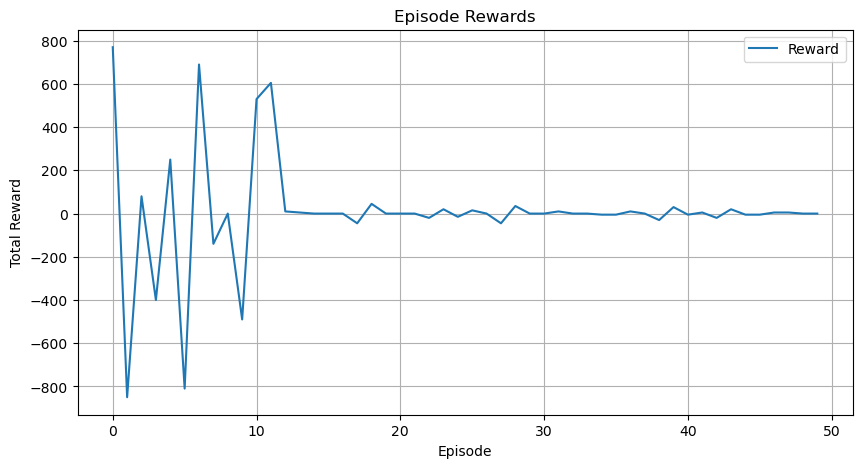

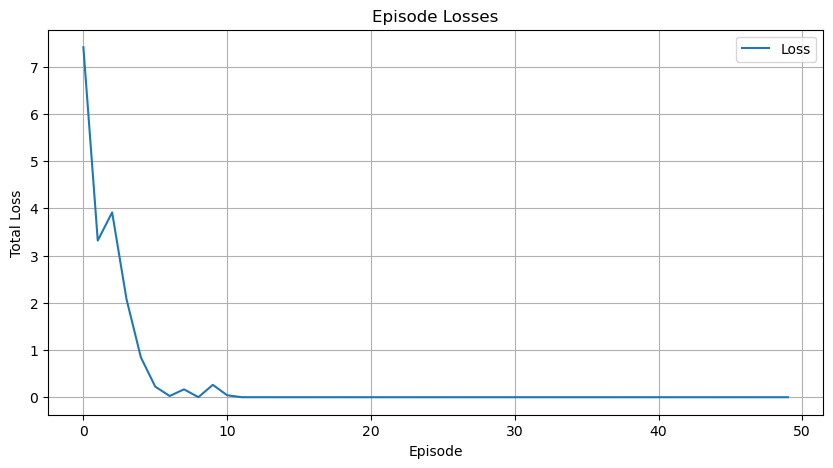

In [19]:
train(num_episodes = 50, episode_length = 10000, learning_rate = 0.0001, render = False)

**Testing model:**

In [22]:
def test(model_path, num_episodes=50, episode_length=10000, scenario="deadly_corridor.cfg", map_path='map01', render=False):
    
    # Initialize DoomGame environment and set up the testing scenario
    game = DoomGame()
    game.load_config(scenario)
    game.set_doom_map(map_path)
    game.set_screen_resolution(ScreenResolution.RES_256X160)
    game.set_screen_format(ScreenFormat.RGB24)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)
    game.set_render_messages(False)
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)
    game.add_available_button(Button.MOVE_LEFT)
    game.add_available_button(Button.MOVE_RIGHT)
    game.add_available_button(Button.TURN_LEFT)
    game.add_available_button(Button.TURN_RIGHT)
    game.add_available_button(Button.MOVE_FORWARD)
    game.add_available_button(Button.MOVE_BACKWARD)
    game.add_available_button(Button.ATTACK)
    game.add_available_button(Button.TURN_LEFT_RIGHT_DELTA, 90)
    game.add_available_button(Button.LOOK_UP_DOWN_DELTA, 90)
    game.set_episode_timeout(6 * episode_length)
    game.set_episode_start_time(10)
    game.set_window_visible(render)
    game.set_sound_enabled(False)
    game.set_living_reward(0)
    game.set_mode(Mode.PLAYER)
    game.init()

    # Load the saved model
    saver = tf.compat.v1.train.import_meta_graph(model_path + '.meta')

    # initialize an array for actions
    actions = np.zeros((game.get_available_buttons_size(), game.get_available_buttons_size()))
    count = 0
    for i in actions:
        i[count] = 1
        count += 1
    actions = actions.astype(int).tolist()

    actionDRQN = DRQN((160, 256, 3), game.get_available_buttons_size() - 2, 0.0001)

    # Start TensorFlow session
    with tf.compat.v1.Session() as sess:
        # Restore the saved variables
        saver.restore(sess, model_path)

        # Initialize all variables (including those restored from the checkpoint)
        sess.run(tf.compat.v1.global_variables_initializer())


        # Testing loop
        rewards = []

        for episode in range(num_episodes):
            game.new_episode()
            total_reward = 0

            for frame in range(episode_length):
                state = game.get_state()
                s = state.screen_buffer

                # Predict action using the loaded model
                a = actionDRQN.prediction.eval(feed_dict={actionDRQN.input: s})[0]
                action = actions[a]

                # Perform action and observe reward
                reward = game.make_action(action)
                total_reward += reward

                if game.is_episode_finished():
                    break

            rewards.append(total_reward)
            print("Episode %d - Total Reward: %.3f" % (episode + 1, total_reward))

        # Plot the rewards
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_episodes + 1), rewards, label='Reward')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Episode Rewards')
        plt.legend()
        plt.grid(True)
        plt.show()


INFO:tensorflow:Restoring parameters from /Users/Lei/Documents/master/semester2/Reinforcement_Learning/cw2/model/train_1


2024-05-02 23:21:07.566529: W tensorflow/c/c_api.cc:291] Operation '{name:'Variable_181/Adam_1/Assign' id:22417 op device:{requested: '', assigned: ''} def:{{{node Variable_181/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_181/Adam_1, Variable_181/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Episode 1 - Total Reward: -115.972
Episode 2 - Total Reward: -105.277
Episode 3 - Total Reward: -115.996
Episode 4 - Total Reward: -115.042
Episode 5 - Total Reward: -112.859
Episode 6 - Total Reward: -115.992
Episode 7 - Total Reward: -114.533
Episode 8 - Total Reward: -110.875
Episode 9 - Total Reward: -112.779
Episode 10 - Total Reward: -115.478
Episode 11 - Total Reward: -115.990
Episode 12 - Total Reward: -115.909
Episode 13 - Total Reward: -115.072
Episode 14 - Total Reward: -115.972
Episode 15 - Total Reward: -115.981
Episode 16 - Total Reward: -115.101
Episode 17 - Total Reward: -112.739
Episode 18 - Total Reward: -112.010
Episode 19 - Total Reward: -114.407
Episode 20 - Total Reward: -115.213
Episode 21 - Total Reward: -114.416
Episode 22 - Total Reward: -113.918
Episode 23 - Total Reward: -114.881
Episode 24 - Total Reward: -100.896
Episode 25 - Total Reward: -114.898
Episode 26 - Total Reward: -112.481
Episode 27 - Total Reward: -115.988
Episode 28 - Total Reward: -108.582
E

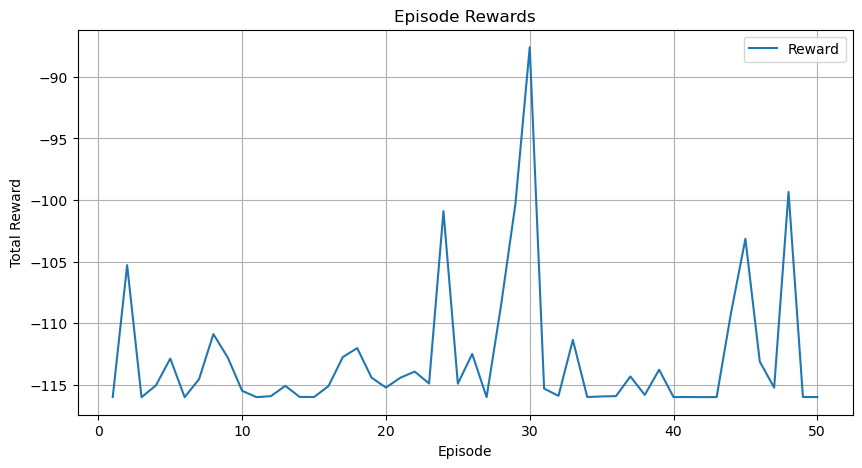

In [23]:
test('/Users/Lei/Documents/master/semester2/Reinforcement_Learning/cw2/model/train_1')